# Home Credit Default Risk - Exploration + Baseline Model

In [1]:
from plotly.offline import init_notebook_mode, iplot
from wordcloud import WordCloud
import plotly.graph_objs as go
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.plotly as py
from plotly import tools
from datetime import date
import pandas as pd
import numpy as np 
import seaborn as sns
import random 
import math
import warnings
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

path = "./input/"

In [2]:
app_train = pd.read_csv(path + "application_train.csv")
bureau = pd.read_csv(path + "bureau.csv")
bureau_balance = pd.read_csv(path + "bureau_balance.csv")
credit_card_balance = pd.read_csv(path + "credit_card_balance.csv")
pcb = pd.read_csv(path + "POS_CASH_balance.csv")
previous_application = pd.read_csv(path + "previous_application.csv")
installments_payments = pd.read_csv(path + "installments_payments.csv")

## <a id="1">1. Baseline Model </a>

### <a id="1.1">1.1 Dataset Preparation</a>

In [3]:
from sklearn.model_selection import train_test_split 
import lightgbm as lgb

# read the test files 
app_test = pd.read_csv(path + 'application_test.csv')

app_test['is_test'] = 1 
app_test['is_train'] = 0
app_train['is_test'] = 0
app_train['is_train'] = 1

# target variable
Y = app_train['TARGET']
train_X = app_train.drop(['TARGET'], axis = 1)

# test ID
test_id = app_test['SK_ID_CURR']
test_X = app_test

# merge train and test datasets for preprocessing
data = pd.concat([train_X, test_X], axis=0)

### <a id="1.2">1.2 Handelling Categorical Features</a>

In [4]:
# function to obtain Categorical Features
def _get_categorical_features(df):
    feats = [col for col in list(df.columns) if df[col].dtype == 'object']
    return feats

# function to factorize categorical features
def _factorize_categoricals(df, cats):
    for col in cats:
        df[col], _ = pd.factorize(df[col])
    return df 

# function to create dummy variables of categorical features
def _get_dummies(df, cats):
    for col in cats:
        df = pd.concat([df, pd.get_dummies(df[col], prefix=col)], axis=1)
    return df 

# get categorical features
data_cats = _get_categorical_features(data)
prev_app_cats = _get_categorical_features(previous_application)
bureau_cats = _get_categorical_features(bureau)
pcb_cats = _get_categorical_features(pcb)
ccbal_cats = _get_categorical_features(credit_card_balance)

# create additional dummy features - 
previous_application = _get_dummies(previous_application, prev_app_cats)
bureau = _get_dummies(bureau, bureau_cats)
pcb = _get_dummies(pcb, pcb_cats)
credit_card_balance = _get_dummies(credit_card_balance, ccbal_cats)

# factorize the categorical features from train and test data
data = _factorize_categoricals(data, data_cats)

### <a id="1.3">1.3 Feature Engineering</a>

### <a id="1.3.1">1.3.1 Feature Engineering - Previous Applications</a>

Credits to excellent kernel shared by Olivier for more ideas: https://www.kaggle.com/ogrellier/good-fun-with-ligthgbm 

In [5]:
## More Feature Ideas Reference : https://www.kaggle.com/ogrellier/good-fun-with-ligthgbm 

## count the number of previous applications for a given ID
prev_apps_count = previous_application[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
previous_application['SK_ID_PREV'] = previous_application['SK_ID_CURR'].map(prev_apps_count['SK_ID_PREV'])

## Average values for all other features in previous applications
prev_apps_avg = previous_application.groupby('SK_ID_CURR').mean()
prev_apps_avg.columns = ['p_' + col for col in prev_apps_avg.columns]
data = data.merge(right=prev_apps_avg.reset_index(), how='left', on='SK_ID_CURR')

### <a id="1.3.2">1.3.2 Feature Engineering - Bureau Data</a>

In [6]:
# Average Values for all bureau features 
bureau_avg = bureau.groupby('SK_ID_CURR').mean()
bureau_avg['buro_count'] = bureau[['SK_ID_BUREAU','SK_ID_CURR']].groupby('SK_ID_CURR').count()['SK_ID_BUREAU']
bureau_avg.columns = ['b_' + f_ for f_ in bureau_avg.columns]
data = data.merge(right=bureau_avg.reset_index(), how='left', on='SK_ID_CURR')


### <a id="1.3.3">1.3.3 Feature Engineering - Previous Installments</a>

In [7]:
## count the number of previous installments
cnt_inst = installments_payments[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
installments_payments['SK_ID_PREV'] = installments_payments['SK_ID_CURR'].map(cnt_inst['SK_ID_PREV'])

## Average values for all other variables in installments payments
avg_inst = installments_payments.groupby('SK_ID_CURR').mean()
avg_inst.columns = ['i_' + f_ for f_ in avg_inst.columns]
data = data.merge(right=avg_inst.reset_index(), how='left', on='SK_ID_CURR')

### <a id="1.3.4">1.3.4 Feature Engineering - Pos Cash Balance</a>

In [8]:
### count the number of pos cash for a given ID
pcb_count = pcb[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
pcb['SK_ID_PREV'] = pcb['SK_ID_CURR'].map(pcb_count['SK_ID_PREV'])

## Average Values for all other variables in pos cash
pcb_avg = pcb.groupby('SK_ID_CURR').mean()
data = data.merge(right=pcb_avg.reset_index(), how='left', on='SK_ID_CURR')

### <a id="1.3.5">1.3.5 Feature Engineering - Credit Card Balance </a>

In [9]:
### count the number of previous applications for a given ID
nb_prevs = credit_card_balance[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
credit_card_balance['SK_ID_PREV'] = credit_card_balance['SK_ID_CURR'].map(nb_prevs['SK_ID_PREV'])

### average of all other columns 
avg_cc_bal = credit_card_balance.groupby('SK_ID_CURR').mean()
avg_cc_bal.columns = ['cc_bal_' + f_ for f_ in avg_cc_bal.columns]
data = data.merge(right=avg_cc_bal.reset_index(), how='left', on='SK_ID_CURR')

### <a id="1.3.6">1.3.6 Prepare Final Train and Test data</a>

In [10]:
#### prepare final Train X and Test X dataframes 
ignore_features = ['SK_ID_CURR', 'is_train', 'is_test']
relevant_features = [col for col in data.columns if col not in ignore_features]
trainX = data[data['is_train'] == 1][relevant_features]
testX = data[data['is_test'] == 1][relevant_features]

### <a id="1.4">1.4 Create Train and Validation Sets</a>

In [11]:
x_train, x_val, y_train, y_val = train_test_split(trainX, Y, test_size=0.2, random_state=18)

### <a id="1.5">1.5 Fit the LightGBM Model</a>

In [12]:
lgb_train = lgb.Dataset(data=x_train, label=y_train)
lgb_eval = lgb.Dataset(data=x_val, label=y_val)

In [13]:
params = {'task': 'train', 
          'boosting_type': 'gbdt', 
          'objective': 'binary', 
          'metric': 'auc', 
          'learning_rate': 0.01, 
          'num_leaves': 48, 
          'num_iteration': 5000, 
          'verbose': 0 ,
          'colsample_bytree':.8, 
          'subsample':.9, 
          'max_depth':7, 
          'reg_alpha':.1, 
          'reg_lambda':.1, 
          'min_split_gain':.01, 
          'min_child_weight':1}
model = lgb.train(params, lgb_train, valid_sets=lgb_eval, early_stopping_rounds=150, verbose_eval=200)

Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.746071
[400]	valid_0's auc: 0.760976
[600]	valid_0's auc: 0.770825
[800]	valid_0's auc: 0.775507
[1000]	valid_0's auc: 0.777815
[1200]	valid_0's auc: 0.779362
[1400]	valid_0's auc: 0.780163
[1600]	valid_0's auc: 0.780651
[1800]	valid_0's auc: 0.780958
[2000]	valid_0's auc: 0.781184
[2200]	valid_0's auc: 0.781256
[2400]	valid_0's auc: 0.781321
[2600]	valid_0's auc: 0.781402
[2800]	valid_0's auc: 0.781418
Early stopping, best iteration is:
[2686]	valid_0's auc: 0.781434


### <a id="1.5.1">1.5.1 Feature Importance </a>

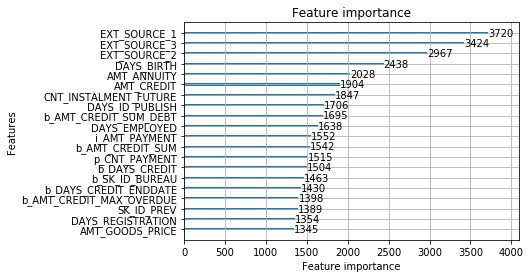

In [14]:
lgb.plot_importance(model, max_num_features=20);

### <a id="1.5.2">1.5.2 Output Prediction On Validation Dataset </a>

In [15]:
segment_list = ['NAME_CONTRACT_TYPE',
                'CODE_GENDER',
                'FLAG_OWN_CAR',
                'FLAG_OWN_REALTY',
                'NAME_TYPE_SUITE',
                'NAME_INCOME_TYPE',
                'NAME_EDUCATION_TYPE',
                'NAME_FAMILY_STATUS',
                'NAME_HOUSING_TYPE',
                'FLAG_MOBIL',
                'FLAG_EMP_PHONE',
                'FLAG_WORK_PHONE',
                'FLAG_CONT_MOBILE',
                'FLAG_PHONE',
                'FLAG_EMAIL',
                'OCCUPATION_TYPE',
                'REG_REGION_NOT_LIVE_REGION',
                'REG_REGION_NOT_WORK_REGION',
                'LIVE_REGION_NOT_WORK_REGION',
                'REG_CITY_NOT_LIVE_CITY',
                'REG_CITY_NOT_WORK_CITY',
                'LIVE_CITY_NOT_WORK_CITY',
                'ORGANIZATION_TYPE',
                'FLAG_DOCUMENT_2',
                'FLAG_DOCUMENT_3',
                'FLAG_DOCUMENT_4',
                'FLAG_DOCUMENT_5',
                'FLAG_DOCUMENT_6',
                'FLAG_DOCUMENT_7',
                'FLAG_DOCUMENT_8',
                'FLAG_DOCUMENT_9',
                'FLAG_DOCUMENT_10',
                'FLAG_DOCUMENT_11',
                'FLAG_DOCUMENT_12',
                'FLAG_DOCUMENT_13',
                'FLAG_DOCUMENT_14',
                'FLAG_DOCUMENT_15',
                'FLAG_DOCUMENT_16',
                'FLAG_DOCUMENT_17',
                'FLAG_DOCUMENT_18',
                'FLAG_DOCUMENT_19',
                'FLAG_DOCUMENT_20',
                'FLAG_DOCUMENT_21',
               ]

In [16]:
preds = model.predict(x_val)

In [17]:
sub_lgb = x_val[segment_list].copy()
sub_lgb['TARGET'] = y_val
sub_lgb['lgb_score'] = preds

### <a id="1.5.3">1.5.3 Explore Gaichart On Validation Dataset </a>

In [45]:
def operation_performance(data, score, weights=None, badTag=None, groups=None,
                          filters=None, catches=None, points=100., rank_base='dummy_weight') :
    '''
    Obtain granularized operating points (as catch / population) depending on model scores,
    Then calculate the cut_off score, amount, catch rate, hit rate in each catergory
    '''

    if weights in [None, []]:
        data['dummy_weight'] = np.ones(data.shape[0], dtype='int64')
        weights = ['dummy_weight']
    if not rank_base:
        data['dummy_weight'] = np.ones(data.shape[0], dtype='int64')
        rank_base = 'dummy_weight'
    if badTag is None:
        badTag = 'is_bad'
    if groups in [None, []]:
        data['dummy_group'] = np.ones(data.shape[0], dtype='int64')
        groups = ['dummy_group']
    if catches in [None, []]:
        catches = []

    raw = data[[score] + weights + [badTag] + groups + catches]

    score_rank = "cut_off"
    # Assuming higher score indicates higher risk
    raw.loc[:, score_rank] = raw.groupby(groups)[score].transform(pd.Series.rank, method='min', ascending=False, na_option='bottom')
    score_groups = groups + [score_rank]
    raw.sort_values(by=score_groups, inplace=True)
    #rank_cumsum = pd.DataFrame(raw.groupby(score_groups)[rank_base].sum().groupby(level=-2).cumsum(),
    #                           columns=["rank_cumsum"]).reset_index()
    rank_cumsum = pd.DataFrame(raw.groupby(score_groups)[rank_base].sum().groupby(level=groups).cumsum().reset_index())
    rank_cumsum.columns = pd.Index(score_groups + ['rank_cumsum'])
    raw = raw.merge(rank_cumsum, how="left", on=score_groups)
    raw.loc[:, score_rank] = raw['rank_cumsum'] / raw.groupby(groups)[rank_base].transform(pd.Series.sum)
    raw.loc[:, score_rank] = raw[score_rank].apply(lambda x: math.ceil(x * points) * (1.0 / points))
    raw.pop('rank_cumsum')

    bad_dummy_names = {}
    full_bads_dummy_names = []
    bad_dummy = pd.get_dummies(raw[badTag])
    bad_dummy.rename(columns=dict(zip(bad_dummy.columns, ["{}|{}".format(x[0], x[1]) for x in zip([badTag] * len(bad_dummy.columns), bad_dummy.columns)])), inplace=True)
    raw = raw.merge(bad_dummy, left_index=True, right_index=True)
    bad_dummy_names[badTag] = list(bad_dummy.columns)
    full_bads_dummy_names.extend(bad_dummy.columns)

    weights_bads_names = [x + '|' + y for x in weights for y in full_bads_dummy_names]
    weights_bads_raw = pd.concat([raw[full_bads_dummy_names].mul(raw[x], axis=0) for x in weights], axis=1)
    weights_bads_raw.columns = pd.Index(weights_bads_names)
    raw[weights_bads_names] = weights_bads_raw

    score_cut_offs = raw.groupby(score_groups)[score].min()
    score_cut_offs.name = 'cut_off_score'
    sums = raw.groupby(score_groups)[weights_bads_names + weights + catches].sum()
    totals = sums.sum(level=groups)
    sums = sums.groupby(level=groups).cumsum()

    # Catch rates
    if type(totals.index) is pd.MultiIndex :
        catch_rates_parts = []
        for tidx in totals.index :
            catch_rates_part = sums.loc[tidx, :].divide(totals.loc[tidx, :] + 1e-20, axis=1)
            new_idx = [[x] for x in tidx]
            new_idx.append(catch_rates_part.index)
            catch_rates_part.index = pd.MultiIndex.from_product(new_idx)
            catch_rates_part.index.names = score_groups
            catch_rates_parts.append(catch_rates_part)
        catch_rates = pd.concat(catch_rates_parts)
    else :
        catch_rates = sums.divide(totals + 1e-20, axis=0)
    catch_rates.columns = [x + '|catch_rate' for x in catch_rates.columns]

    # False positive rate
    fpr_list = []
    fpr_names = []
    for weight in weights:
        weight_neg_names = [weight + '|' + badTag + '|' + neg for neg in negTags]
        weight_pos_names = [weight + '|' + badTag + '|' + pos for pos in posTags]
        fpr = sums[weight_neg_names].sum(axis=1).divide(sums[weight_pos_names].sum(axis=1))
        fpr_list.append(fpr)
        fpr_names.append(weight + '|' + badTag + '|' + '_'.join(negTags) + '|' + '_'.join(posTags) + '|FPR')
    fprs = pd.concat(fpr_list, axis=1)
    fprs.columns = pd.Index(fpr_names)

    # Hit rates
    hit_rate_list = []
    hit_rate_names = []
    for weight in weights :
        weight_bads_names = [weight + '|' + x for x in full_bads_dummy_names]
        hit_rate = sums[weight_bads_names].divide(sums[weight] + 1e-20, axis=0)
        hit_rate_list.append(hit_rate)
        hit_rate_names.extend([x + '|hit_rate' for x in weight_bads_names])
    hit_rates = pd.concat(hit_rate_list, axis=1)
    hit_rates.columns = pd.Index(hit_rate_names)

    raw_output = pd.concat([score_cut_offs, sums, catch_rates, hit_rates, fprs], axis=1)
    raw_output.reset_index(inplace=True)
    raw_output['score_name'] = score
    raw_output['rank_base'] = rank_base
    raw_output['group_name'] = ",".join(groups)
    raw_output['filter_name'] = filters
    return raw_output

In [234]:
seg = segment_list[42]
print('{} -- {}'.format(seg, list(app_train[seg].unique())))
scores = ['lgb_score']
weights = []
rank_base = ''
badTag = 'TARGET'
posTags = ['1']
negTags = ['0']
groups = [seg]
group_by_month = False
filters = ''
points = 1000

FLAG_DOCUMENT_21 -- [0, 1]


In [235]:
first = True
for score in scores:
    print('Processing ' + score)
    performance_i = operation_performance(sub_lgb, score=score, weights=weights, badTag=badTag, groups=groups,
                                          filters=filters, catches=None, points = points, rank_base=rank_base)
    if first:
        performance = performance_i
        first = False
    else:
        performance = pd.concat([performance, performance_i], axis=0)

Processing lgb_score


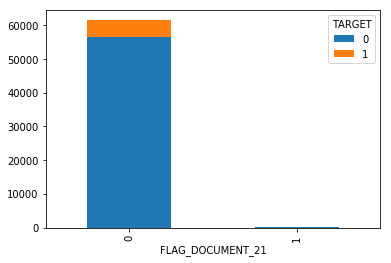

In [236]:
sub_lgb.groupby(['TARGET'])[seg].value_counts().unstack('TARGET').plot(kind='bar', stacked=True)
plt.show()

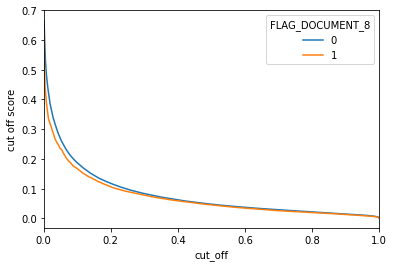

In [196]:
performance.groupby(['cut_off', seg]).mean()['cut_off_score'].unstack().plot()
plt.ylabel('cut off score')
plt.show()

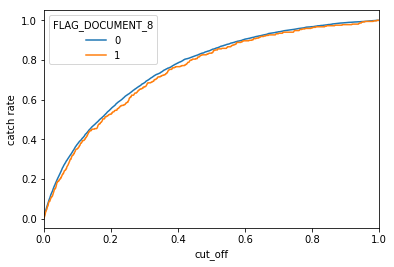

In [197]:
performance.groupby(['cut_off', seg]).mean()['dummy_weight|TARGET|1|catch_rate'].unstack().plot()
plt.ylabel('catch rate')
plt.show()

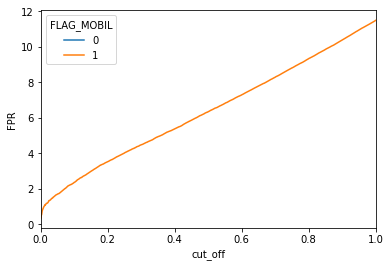

In [102]:
performance.groupby(['cut_off', seg]).mean()['dummy_weight|TARGET|0|1|FPR'].unstack().plot()
plt.ylabel('FPR')
plt.show()

### <a id="1.7">1.7 Predict</a>

In [ ]:
preds = model.predict(testX)
sub_lgb = pd.DataFrame()
sub_lgb['SK_ID_CURR'] = test_id
sub_lgb['TARGET'] = preds
sub_lgb.to_csv("lgb_baseline.csv", index=False)
sub_lgb.head()

#### The output file scores 0.772 on the leaderboard.

Thanks for viewing. 